In [2]:
import tensorflow as tf 
%matplotlib inline 
import matplotlib.pylab as plt
import numpy as np
from keras.preprocessing import image

Using TensorFlow backend.


# task: classifcation cars
 * firebrigades
 * police cars
 * rescue cars

### Constants

In [3]:
IMAGE_DIR = './images'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE  = 32

## Generate Generators training & validation

In [4]:

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation') # set as validation data

Found 475 images belonging to 3 classes.
Found 201 images belonging to 3 classes.


### found classes 

In [5]:
print(train_generator.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


### display samples from training set


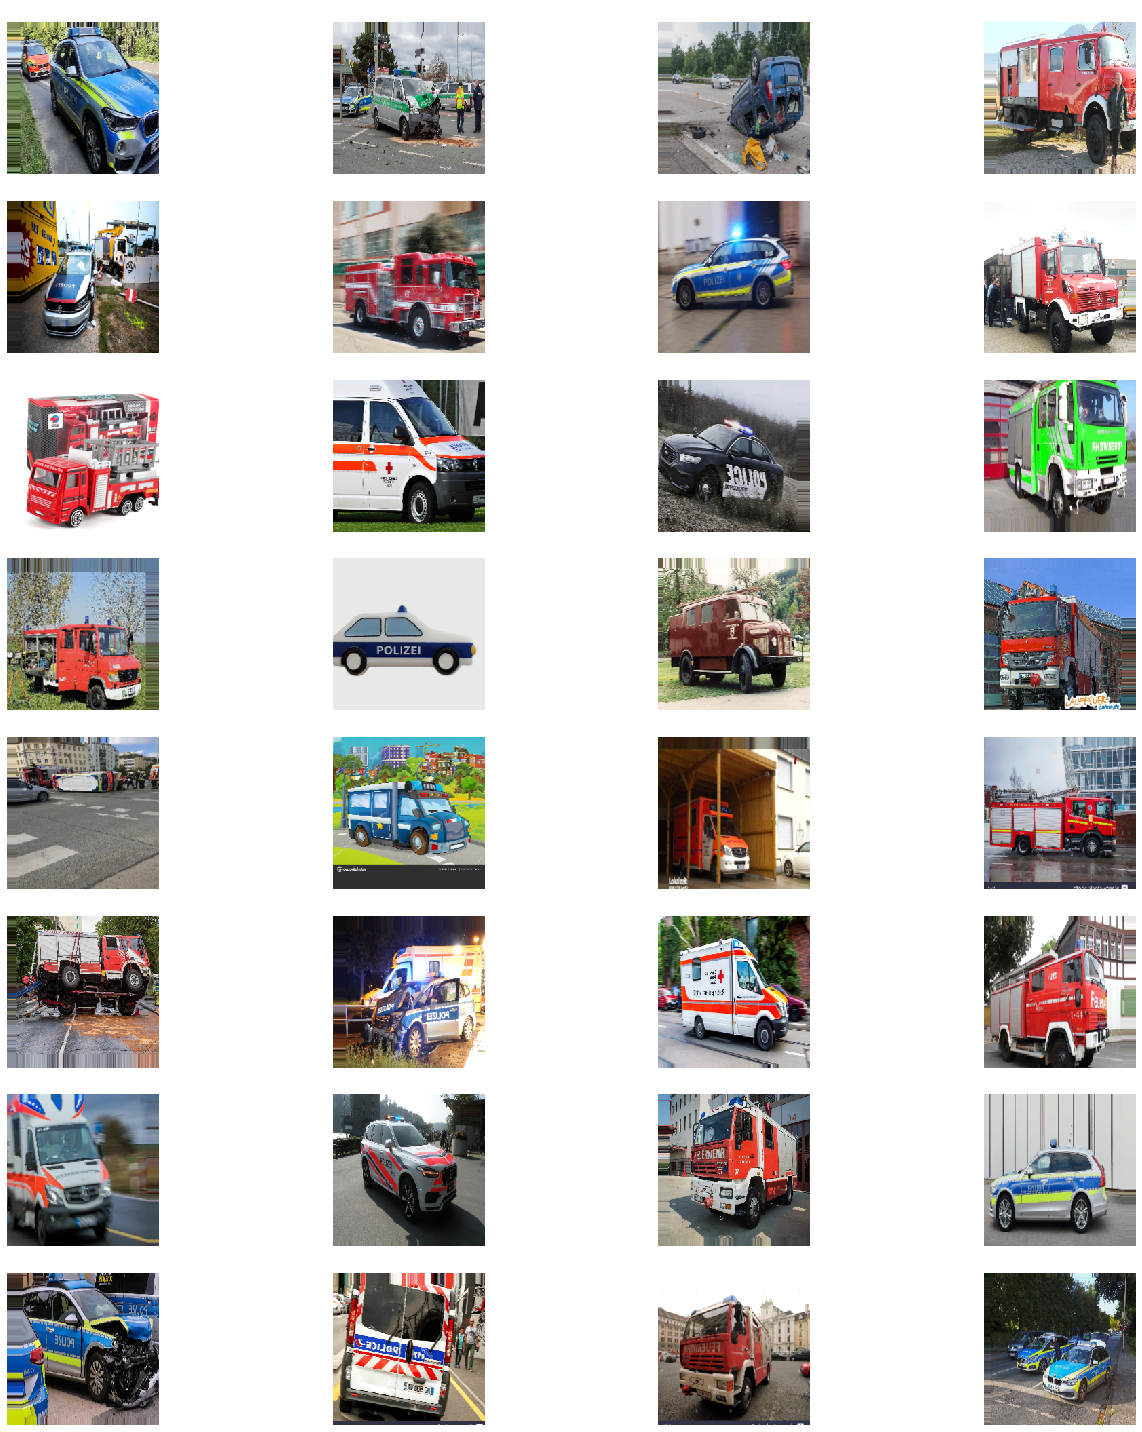

In [6]:
sample_training_images, labels = next(train_generator)
class_label = {v:k for k,v in train_generator.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

### Image classification modelling - Model 1

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(train_generator.num_classes, 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [6]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()]
        
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()]

    def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)


In [8]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 7, strides=2, padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])

model = top_model

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
    
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.summary()

ValueError: in converted code:

    <ipython-input-6-3edc1fb042d0>:25 call  *
        return self.activation(Z + skip_Z)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\ops\math_ops.py:899 binary_op_wrapper
        return func(x, y, name=name)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\ops\math_ops.py:1197 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\ops\gen_math_ops.py:549 add_v2
        "AddV2", x=x, y=y, name=name)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\framework\op_def_library.py:793 _apply_op_helper
        op_def=op_def)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\framework\func_graph.py:548 create_op
        compute_device)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\framework\ops.py:3429 _create_op_internal
        op_def=op_def)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\framework\ops.py:1773 __init__
        control_input_ops)
    C:\Users\Benni\Anaconda3\envs\akt\lib\site-packages\tensorflow_core\python\framework\ops.py:1613 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 64 and 32 for 'residual_unit_1/add' (op: 'AddV2') with input shapes: [?,56,56,64], [?,56,56,32].


## helper function

In [8]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            print("skip broken image")
            pass

In [9]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

In [10]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

history = model.fit_generator(
    skip_broken_images(train_generator),
    steps_per_epoch=20, #use way more steps here: number of samples / batch size
    epochs=5, #use way more or use EarlyStopping callback
    validation_data=skip_broken_images(validation_generator),
    validation_steps=5,
    callbacks=[snapshot_callback]
)

Epoch 1/5
19/20 [===========================>..] - ETA: 5s - loss: 1.3723 - categorical_accuracy: 0.4395skip broken image

Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots/assets
20/20 [==============================] - 145s 7s/step - loss: 1.3462 - categorical_accuracy: 0.4472 - val_loss: 0.7411 - val_categorical_accuracy: 0.6750
Epoch 2/5
19/20 [===========================>..] - ETA: 4s - loss: 0.6630 - categorical_accuracy: 0.7048skip broken image

Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots/assets
20/20 [==============================] - 113s 6s/step - loss: 0.6713 - categorical_accuracy: 0.7024 - val_loss: 0.5809 - val_categorical_accuracy: 0.7153
Epoch 3/5
10/20 [==============>...............] - ETA: 39s - loss: 0.6044 - categorical_accuracy: 0.7714

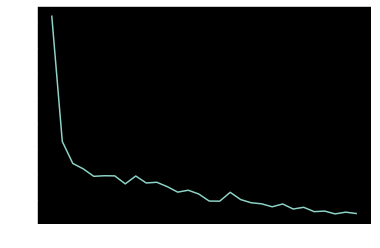

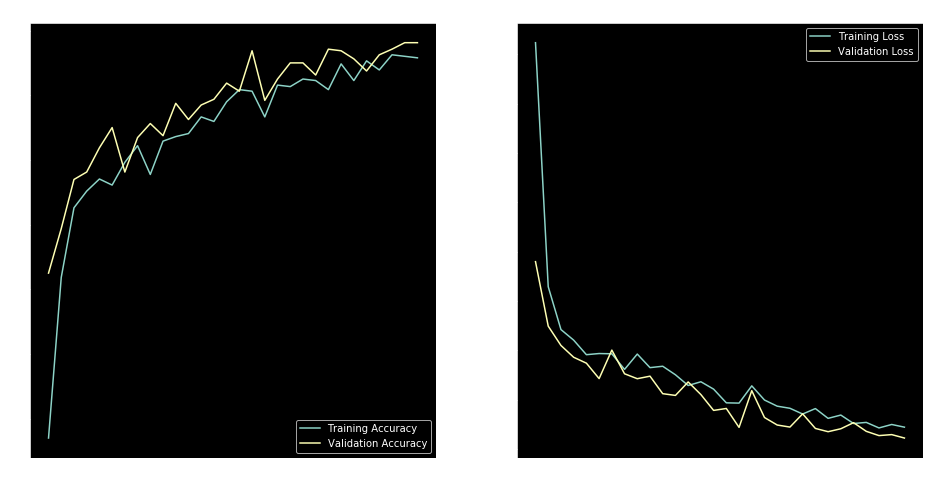

In [10]:
plt.plot(history.history['loss'])

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
model.save('cars.h5')

* test the data
*  calculate accuracy 

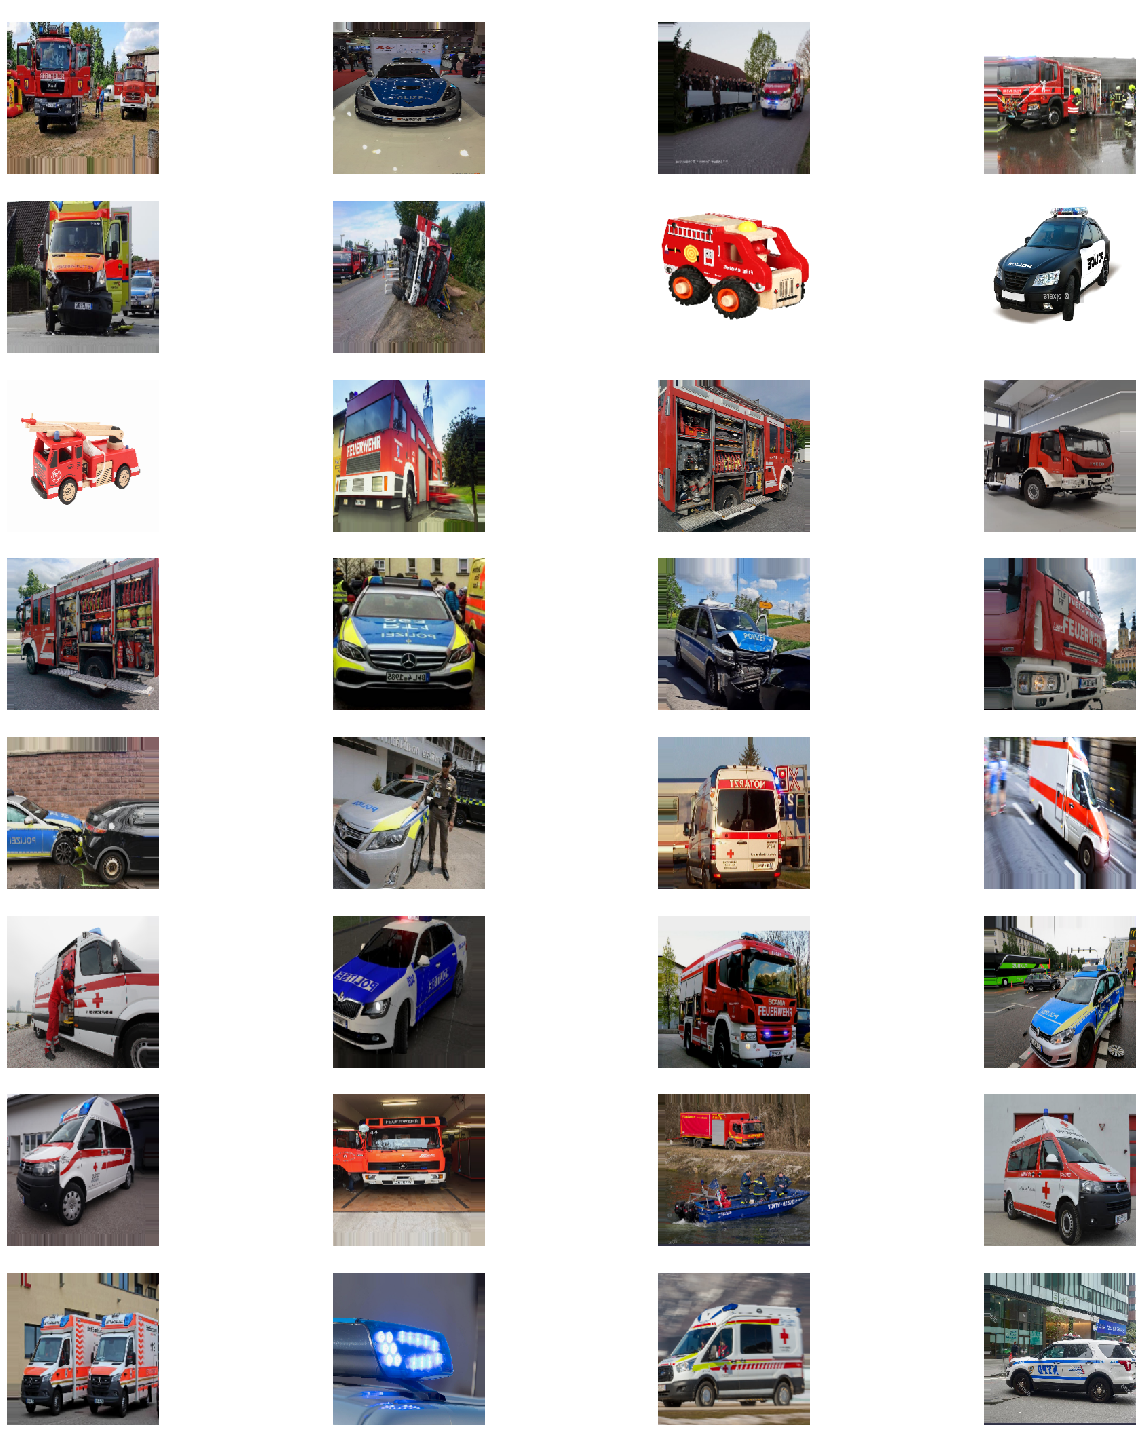

In [18]:
sample_training_images, labels = next(train_data_gen)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(sample_training_images, axes):
    img2 = np.expand_dims(img, axis=0)
    result = model.predict_classes(img2)
    ax.set_title(class_label[result[0]])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

In [0]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [0]:
image_path="./images/fire/33.596_678227509643.jpg"
img = image.load_img(image_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
 
# decode the results into a list of tuples (class, description, probability)
print(preds)

class_label[np.argmax(preds)]



In [0]:
print(class_label[0])